**Group Members**



*   Aman Vishani - B00840115
*   Karthikk Tamil mani - B00838575



In [0]:
%matplotlib inline

In [0]:
# PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision for loading MNIST dataset
import torchvision
from torchvision import datasets, transforms

# For plotting
import matplotlib.pyplot as plt

from sklearn import decomposition
from tqdm.notebook import tqdm
from sklearn import datasets as skdatasets
import numpy as np

In [0]:
def create_dataloader(x, y, batch_sz=200):
  if type(x) is np.ndarray:
    tensor_x = torch.Tensor(x) # transform to torch tensor
  else:
    tensor_x = x

  if type(y) is np.ndarray:
    tensor_y = torch.Tensor(y)
  else:
    tensor_y = y
    
  my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
  my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_sz) # create your dataloader
  return my_dataloader

In [12]:
mnist_transformer = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ])
# Download the training data
train_data = datasets.MNIST('./mnist_data', download=True, train=True,
                            transform=mnist_transformer)

# Download the test data
test_data = datasets.MNIST('./mnist_data', download=True, train=False,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ]))

classes = [i for i in range(10)]

print("Training examples: ", len(train_data))
print("Test examples: ", len(test_data))

Training examples:  60000
Test examples:  10000


In [0]:
test_data.data.size()

torch.Size([10000, 28, 28])

# a) PCA for Data visualization:

In [0]:
iris = skdatasets.load_iris()
X = iris.data
y = iris.target
pca = decomposition.PCA()
pca.fit(X)
X_pca = pca.transform(X)

Following are the variances of first 2 principal components:
[4.22824171 0.24267075]
[0.92461872 0.05306648]


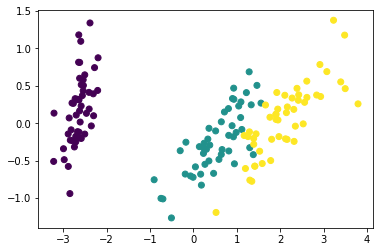

In [99]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
print("Following are the variances of first 2 principal components:")
print(pca.explained_variance_[:2])
print(pca.explained_variance_ratio_[:2])

Following are the variances of last 2 principal components:
[0.0782095  0.02383509]
[0.01710261 0.00521218]


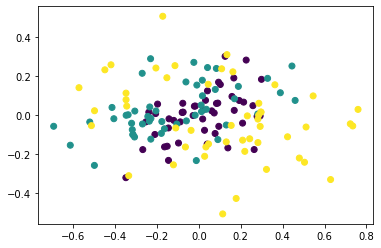

In [100]:
plt.scatter(X_pca[:, -2], X_pca[:, -1], c=y)
print("Following are the variances of last 2 principal components:")
print(pca.explained_variance_[-2:])
print(pca.explained_variance_ratio_[-2:])

**Inference**

1. For the 1st 2 principal components, we are able to differentiate between the 3 clusters of data.
2. Whereas, for the last 2 components, we are not able to differentiate the data clearly.

# b) PCA for feature selection

In [0]:
x_train = train_data.data.numpy()
x_train = x_train.reshape(-1, 28*28)
x_test = test_data.data.numpy()
x_test = x_test.reshape(-1, 28*28)

## (i) use the retained features to train a simple feed-forward neural network with one hidden layer to classify the images

In [0]:
pca = decomposition.PCA()
pca.fit(x_train)
X_pca = pca.transform(x_train)

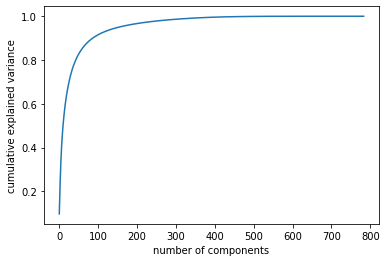

In [15]:
cum_sum_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_sum_var_ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [16]:
component_num_50 = np.argmax(cum_sum_var_ratio > 0.50)
print("Number of Components for 50%:", component_num_50)

Number of Components for 50%: 10


In [17]:
component_num_75 = np.argmax(cum_sum_var_ratio > 0.75)
print("Number of Components for 75%:", component_num_75)

Number of Components for 75%: 33


In [18]:
component_num_90 = np.argmax(cum_sum_var_ratio > 0.90)
print("Number of Components for 90%:", component_num_90)

Number of Components for 90%: 86


In [19]:
component_num_95 = np.argmax(cum_sum_var_ratio > 0.95)
print("Number of Components for 95%:", component_num_95)

Number of Components for 95%: 153


In [0]:
def compressUsingPCA(varianceLevel):
  pca = decomposition.PCA(varianceLevel)
  pca.fit(x_train)
  return pca.transform(x_train), pca.transform(x_test)

In [0]:
# Util Code for calculating Accrucacy
def accrucacy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  total = labels.size(0)
  correct = (predicted == labels).sum().item()
  return correct / total

In [0]:
class FcNet(nn.Module):
    def __init__(self, input_dim=None, num_hidden_units=20):
      super(FcNet, self).__init__()
      self.fch = nn.Linear(input_dim, num_hidden_units)
      self.fco = nn.Linear(num_hidden_units, 10)

    def forward(self, x):
      x = F.relu(self.fch(x))
      x = torch.log_softmax(self.fco(x), dim=1)
      return x

In [0]:
def evaluate_NN(model, data, targets):
  with torch.no_grad():
    inputs, labels = data, targets
    if type(inputs) is np.ndarray:
      inputs = torch.autograd.Variable(torch.from_numpy(inputs))
    inputs = inputs.float()
    outputs = model(inputs)
    return accrucacy(outputs, labels)

In [0]:
def train_FNN(data, num_hidden_units=20, epochs = 100, batch=200):

  component_nums = data.shape[1]

  train_acc = []
  
  model = FcNet(component_nums, num_hidden_units)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=(0.01)/batch, momentum=0.9) # lr = learning rate/step size
  dataloader = create_dataloader(data , train_data.targets, batch)
  ##### Training the network ###################################################
  for e in tqdm(range(epochs)):  # loop over the dataset multiple times
    for x,y in dataloader:
      optimizer.zero_grad() # zero the parameter gradients
      # x = torch.autograd.Variable(torch.from_numpy(x))
      x = x.float()
      outputs = model(x) # forward pass
    
      ## Train Acc
      train_acc.append(accrucacy(outputs, y))
    
      loss = criterion(outputs, y) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update
  plt.plot(train_acc, linestyle='-', color='g', label='Train Accuracy')
  plt.title("Train Accuracy and Mini batch epocs")
  plt.xlabel("Epocs")
  plt.ylabel("Accuracy rate");
  plt.legend(loc='best')
  
  return model, train_acc

### 50% Variance


Train Accuracy ...
0.86
Test Accuracy ...
0.7889


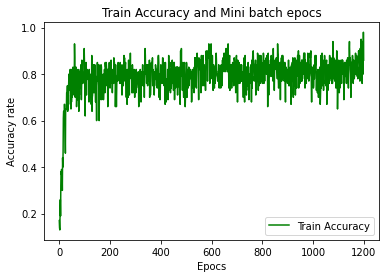

In [0]:
torch.manual_seed(0)
compressedTrainData, compressedTestData = compressUsingPCA(0.50)

trainedModel, train_acc = train_FNN(compressedTrainData, epochs=2, batch=100)

fnn_50_acc = evaluate_NN(trainedModel, compressedTestData, test_data.targets)

print("Train Accuracy ...")
print(train_acc[-1])

print("Test Accuracy ...")
print(fnn_50_acc)

### 75% Variance


Train Accuracy ...
0.86
Test Accuracy ...
0.8648


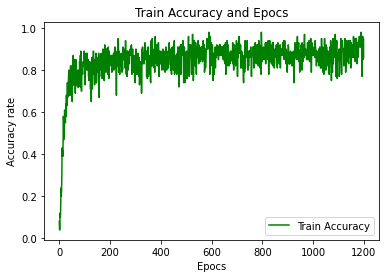

In [0]:
torch.manual_seed(0)
compressedTrainData, compressedTestData = compressUsingPCA(0.75)

trainedModel, train_acc = train_FNN(compressedTrainData, epochs=2, batch=100)

fnn_75_acc = evaluate_NN(trainedModel, compressedTestData, test_data.targets)

print("Train Accuracy ...")
print(train_acc[-1])

print("Test Accuracy ...")
print(fnn_75_acc)

### 90% Variance


Train Accuracy ...
0.85
Test Accuracy ...
0.8867


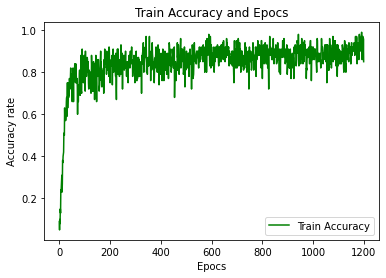

In [0]:
torch.manual_seed(0)
compressedTrainData, compressedTestData = compressUsingPCA(0.90)

trainedModel, train_acc = train_FNN(compressedTrainData, epochs=2, batch=100)

fnn_90_acc = evaluate_NN(trainedModel, compressedTestData, test_data.targets)

print("Train Accuracy ...")
print(train_acc[-1])

print("Test Accuracy ...")
print(fnn_90_acc)

### 95% Variance


Train Accuracy ...
0.91
Test Accuracy ...
0.9022


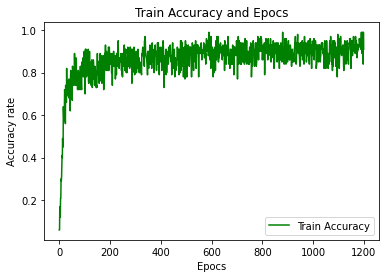

In [0]:
compressedTrainData, compressedTestData = compressUsingPCA(0.95)

trainedModel, train_acc = train_FNN(compressedTrainData, epochs=2, batch=100)

fnn_95_acc = evaluate_NN(trainedModel, compressedTestData, test_data.targets)

print("Train Accuracy ...")
print(train_acc[-1])

print("Test Accuracy ...")
print(fnn_95_acc)

## (ii) reconstruct the 28×28 images from the retained features (obtained using PCA with different variance levels) and train the CNN network defined in Q1 to classify these images.

In [0]:
def eval_CNN(train_loader, test_loader, epochs, batch_size):

  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in tqdm(range(epochs)):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients
      outputs = net(inputs) # forward pass
      
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
    # if True:
      inputs, labels = data
      # inputs = torch.autograd.Variable(torch.from_numpy(inputs))
      # inputs = inputs.float()
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on training data ################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
    # if True:
      inputs, labels = data
      # inputs = torch.autograd.Variable(torch.from_numpy(inputs))
      # inputs = inputs.float()
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

In [0]:
def inverse_pca(num_component=None):
  pca = decomposition.PCA(num_component)
  X_pca = pca.fit_transform(x_train)
  X_reconstruct = pca.inverse_transform(X_pca)
  return X_reconstruct

In [0]:
def visualize_img(X_reconstruct):
  i = 5
  plt.imshow(X_reconstruct[i, :].reshape(28, 28))
  print(train_data.targets.numpy()[i])

In [0]:
def inverse_compressUsingPCA(varianceLevel):
  pca = decomposition.PCA(varianceLevel)
  X_pca_train = pca.fit_transform(x_train)
  X_train_reconstruct = pca.inverse_transform(X_pca_train)
  X_pca_test = pca.fit_transform(x_test)
  X_test_reconstruct = pca.inverse_transform(X_pca_test)
  return X_train_reconstruct, X_test_reconstruct

### 50% Variance

2


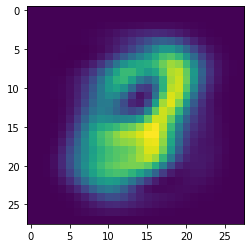

In [0]:
visualize_img(inverse_pca(component_num_50))

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.92055
Test accuracy:  0.9


<Figure size 432x288 with 0 Axes>

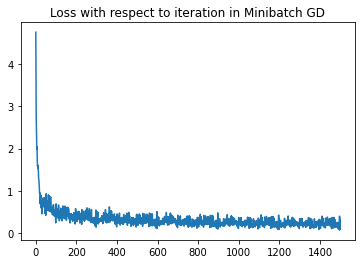

<Figure size 432x288 with 0 Axes>

In [0]:
compressedTrainData, compressedTestData = inverse_compressUsingPCA(0.50)

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, cnn_50_acc = eval_CNN(train_loader, test_loader, epochs=5, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", cnn_50_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

### 75% Variance

2


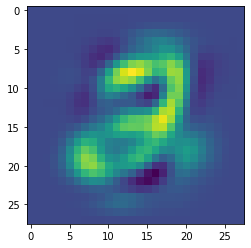

In [0]:
visualize_img(inverse_pca(component_num_75))

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9748666666666667
Test accuracy:  0.9718


<Figure size 432x288 with 0 Axes>

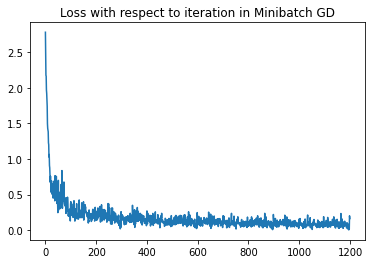

<Figure size 432x288 with 0 Axes>

In [0]:
compressedTrainData, compressedTestData = inverse_compressUsingPCA(0.75)

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses,train_acc, cnn_75_acc = eval_CNN(train_loader, test_loader, epochs=4, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", cnn_75_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

### 90% Variance

2


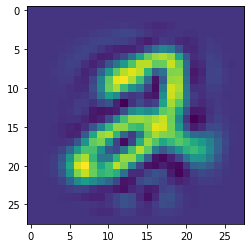

In [0]:
visualize_img(inverse_pca(component_num_90))

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9757833333333333
Test accuracy:  0.9742


<Figure size 432x288 with 0 Axes>

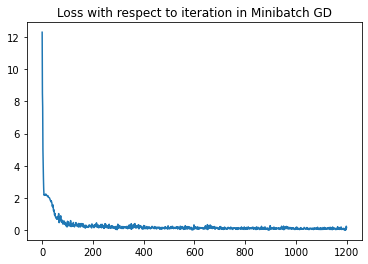

<Figure size 432x288 with 0 Axes>

In [0]:
compressedTrainData, compressedTestData = inverse_compressUsingPCA(0.90)

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses,train_acc, cnn_90_acc = eval_CNN(train_loader, test_loader, epochs=4, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", cnn_90_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

### 95% Variance

2


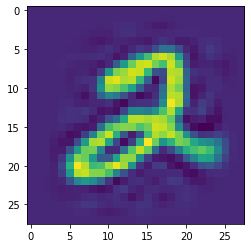

In [0]:
visualize_img(inverse_pca(component_num_95))

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9811
Test accuracy:  0.9795


<Figure size 432x288 with 0 Axes>

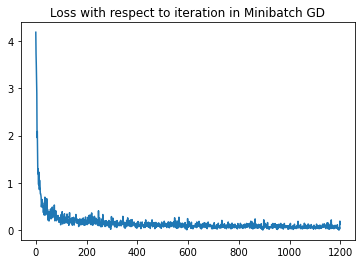

<Figure size 432x288 with 0 Axes>

In [0]:
compressedTrainData, compressedTestData = inverse_compressUsingPCA(0.95)

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses,train_acc, cnn_95_acc = eval_CNN(train_loader, test_loader, epochs=4, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", cnn_95_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## Comparision

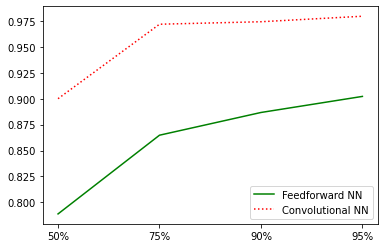

In [0]:
variance_levels = ['50%', '75%', '90%', '95%']
fnn_acc = [fnn_50_acc, fnn_75_acc, fnn_90_acc, fnn_95_acc]
cnn_acc = [cnn_50_acc, cnn_75_acc, cnn_90_acc, cnn_95_acc]
plt.plot(fnn_acc, linestyle='-', color='g', label='Feedforward NN')
plt.plot(cnn_acc, linestyle=':', color='r', label='Convolutional NN')
plt.xticks([0, 1, 2, 3], variance_levels)
plt.legend(loc='best')

**Comments**

1. Overall, CNN is performing better than the FNN since images are higher dimensional data and CNN does have filters to work with images.
2. Also, for variance over 75% there is not much improvements in the accuracy of both the models, since 75% retains most valuable information and seems to be an ideal one.

# c) Linear AutoEncoder for MNIST Digits

In [0]:
mnist_transformer = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ])
# Download the training data
train_data = datasets.MNIST('./mnist_data', download=True, train=True,
                            transform=mnist_transformer)

# Download the test data
test_data = datasets.MNIST('./mnist_data', download=True, train=False,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ]))

In [0]:
from torch.utils.data import DataLoader

In [0]:
class LinearAutoEncoderNet(nn.Module):

  def encode(self, x):
    return self.fch(x)

  def decode(self, x):
    return self.fco(x)

  def __init__(self, num_hidden_units=20):
    super(LinearAutoEncoderNet, self).__init__()
    self.fch = nn.Linear(784, num_hidden_units)
    self.fco = nn.Linear(num_hidden_units, 784)

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x

In [0]:
def train_autoencoder(AutoEncoderNet, component_nums, epochs = 20, batch_size = 500):
  train_loader = DataLoader(train_data, batch_size=batch_size)
  test_loader = DataLoader(test_data, batch_size=batch_size)
  model = AutoEncoderNet(component_nums)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = learning rate/step size
  accs = []
  # inputs = (train_data.data / 255).float()
  ##### Training the network ###################################################
  for e in tqdm(range(epochs)):  # loop over the dataset multiple times
    for data in train_loader:
      inputs, labels = data
      inputs = inputs.view(-1, 784)
      optimizer.zero_grad() # zero the parameter gradients
      outputs = model(inputs) # forward pass
      loss = criterion(outputs, inputs) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update
      accs.append(loss.item())
  plt.plot(accs)
  plt.figure()
  
  return model


In [0]:
def test_model(model, i=2):
  with torch.no_grad():
    image = test_data.data[i,:].view(-1, 28*28).float()
    reconstructed_img = model(image)
    plt.imshow(reconstructed_img.view(28,28))

## 50% Variance

<Figure size 432x288 with 0 Axes>

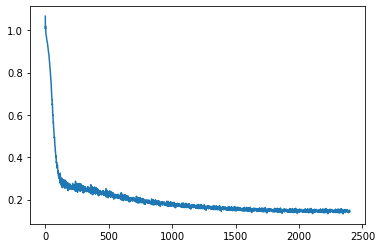

<Figure size 432x288 with 0 Axes>

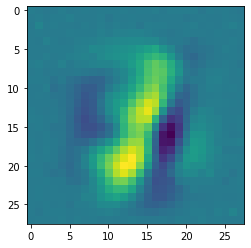

<Figure size 432x288 with 0 Axes>

In [113]:
autoencoder = train_autoencoder(LinearAutoEncoderNet, component_num_50, epochs=20)
plt.figure()

test_model(autoencoder)
plt.figure()


### Feedforward NN


Train Accuracy ...
0.87
Test Accuracy ...
0.8439


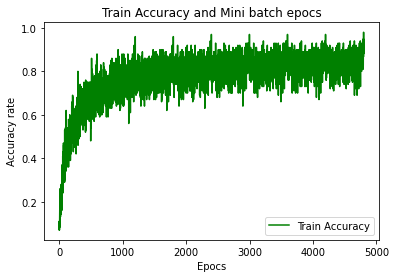

<Figure size 432x288 with 0 Axes>

In [114]:
torch.manual_seed(0)
with torch.no_grad():
  compressedTrainData = autoencoder.encode(train_data.data.reshape(-1, 28*28).float())
  compressedTrainData = compressedTrainData.numpy()
  compressedTestData = autoencoder.encode(test_data.data.reshape(-1, 28*28).float())
  compressedTestData = compressedTestData.numpy()

trainedModel, train_acc = train_FNN(compressedTrainData, epochs=8, batch=100)
plt.figure()

linear_ac_50_acc_fnn = evaluate_NN(trainedModel, compressedTestData, test_data.targets)

print("Train Accuracy ...")
print(train_acc[-1])

print("Test Accuracy ...")
print(linear_ac_50_acc_fnn)

### CNN

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.90095
Test accuracy:  0.9011


<Figure size 432x288 with 0 Axes>

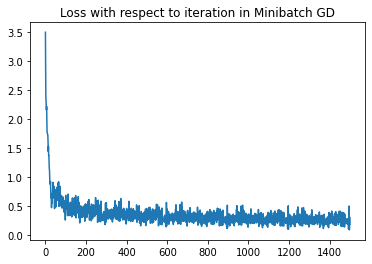

<Figure size 432x288 with 0 Axes>

In [115]:
with torch.no_grad():
  compressedTrainData = autoencoder(train_data.data.reshape(-1, 28*28).float())
  compressedTrainData = compressedTrainData.numpy()
  compressedTestData = autoencoder(test_data.data.reshape(-1, 28*28).float())
  compressedTestData = compressedTestData.numpy()

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, linear_cnn_50_acc = eval_CNN(train_loader, test_loader, epochs=5, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ",  linear_cnn_50_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## 75% Variance

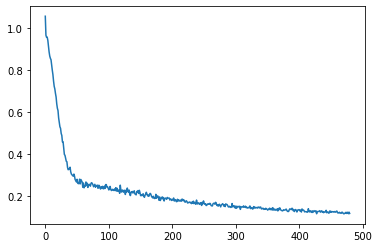

<Figure size 432x288 with 0 Axes>

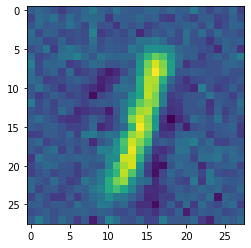

In [116]:
autoencoder = train_autoencoder(LinearAutoEncoderNet, component_num_75, epochs=4)
plt.figure()

test_model(autoencoder)

### Feedforward NN


Train Accuracy ...
0.9
Test Accuracy ...
0.8899


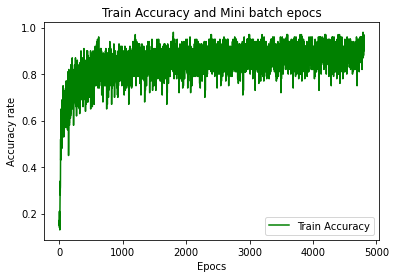

<Figure size 432x288 with 0 Axes>

In [117]:
torch.manual_seed(0)
with torch.no_grad():
  compressedTrainData = autoencoder.encode(train_data.data.reshape(-1, 28*28).float())
  compressedTrainData = compressedTrainData.numpy()
  compressedTestData = autoencoder.encode(test_data.data.reshape(-1, 28*28).float())
  compressedTestData = compressedTestData.numpy()

trainedModel, train_acc = train_FNN(compressedTrainData, epochs=8, batch=100)
plt.figure()

linear_ac_75_acc_fnn = evaluate_NN(trainedModel, compressedTestData, test_data.targets)

print("Train Accuracy ...")
print(train_acc[-1])

print("Test Accuracy ...")
print(linear_ac_75_acc_fnn)

### CNN

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9569666666666666
Test accuracy:  0.9542


<Figure size 432x288 with 0 Axes>

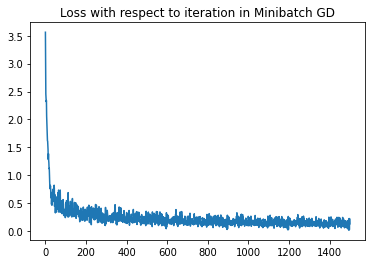

<Figure size 432x288 with 0 Axes>

In [118]:
with torch.no_grad():
  compressedTrainData = autoencoder(train_data.data.reshape(-1, 28*28).float())
  compressedTrainData = compressedTrainData.numpy()
  compressedTestData = autoencoder(test_data.data.reshape(-1, 28*28).float())
  compressedTestData = compressedTestData.numpy()

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, linear_cnn_75_acc = eval_CNN(train_loader, test_loader, epochs=5, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ",  linear_cnn_75_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## 90% Variance

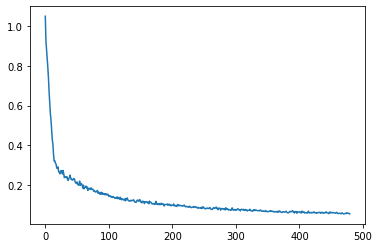

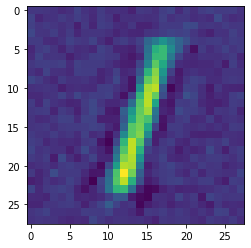

In [119]:
autoencoder = train_autoencoder(LinearAutoEncoderNet, component_num_90, epochs=4)
test_model(autoencoder)

### Feedforward NN


Train Accuracy ...
0.91
Test Accuracy ...
0.9106


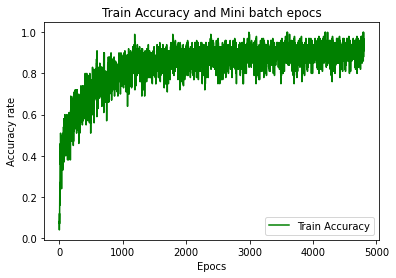

<Figure size 432x288 with 0 Axes>

In [120]:
torch.manual_seed(0)
with torch.no_grad():
  compressedTrainData = autoencoder.encode(train_data.data.reshape(-1, 28*28).float())
  compressedTrainData = compressedTrainData.numpy()
  compressedTestData = autoencoder.encode(test_data.data.reshape(-1, 28*28).float())
  compressedTestData = compressedTestData.numpy()

trainedModel, train_acc = train_FNN(compressedTrainData, epochs=8, batch=100)
plt.figure()

linear_ac_90_acc_fnn = evaluate_NN(trainedModel, compressedTestData, test_data.targets)

print("Train Accuracy ...")
print(train_acc[-1])

print("Test Accuracy ...")
print(linear_ac_90_acc_fnn)

### CNN

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9756333333333334
Test accuracy:  0.9735


<Figure size 432x288 with 0 Axes>

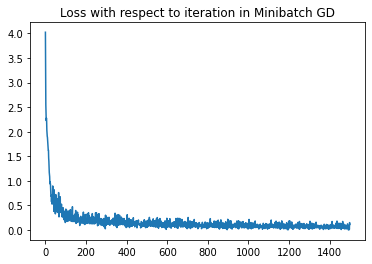

<Figure size 432x288 with 0 Axes>

In [121]:
with torch.no_grad():
  compressedTrainData = autoencoder(train_data.data.reshape(-1, 28*28).float())
  compressedTrainData = compressedTrainData.numpy()
  compressedTestData = autoencoder(test_data.data.reshape(-1, 28*28).float())
  compressedTestData = compressedTestData.numpy()

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, linear_cnn_90_acc = eval_CNN(train_loader, test_loader, epochs=5, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ",  linear_cnn_90_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## 95% Variance

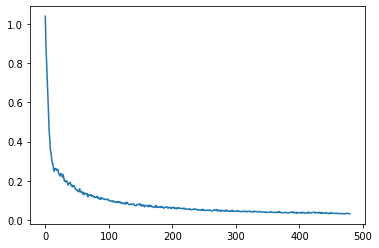

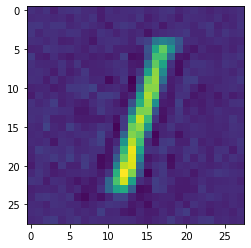

In [110]:
autoencoder = train_autoencoder(LinearAutoEncoderNet, component_num_95, epochs=4)
test_model(autoencoder)

### Feedfoward NN


Train Accuracy ...
0.91
Test Accuracy ...
0.8858


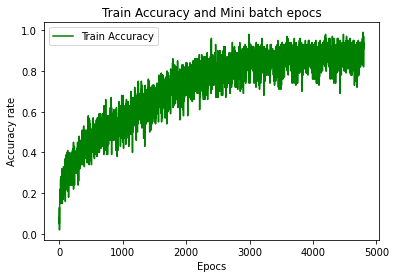

<Figure size 432x288 with 0 Axes>

In [111]:
torch.manual_seed(0)
with torch.no_grad():
  compressedTrainData = autoencoder.encode(train_data.data.reshape(-1, 28*28).float())
  compressedTrainData = compressedTrainData.numpy()
  compressedTestData = autoencoder.encode(test_data.data.reshape(-1, 28*28).float())
  compressedTestData = compressedTestData.numpy()

trainedModel, train_acc = train_FNN(compressedTrainData, epochs=8, batch=100)
plt.figure()

linear_ac_95_acc_fnn = evaluate_NN(trainedModel, compressedTestData, test_data.targets)

print("Train Accuracy ...")
print(train_acc[-1])

print("Test Accuracy ...")
print(linear_ac_95_acc_fnn)

### CNN

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9753166666666667
Test accuracy:  0.9731


<Figure size 432x288 with 0 Axes>

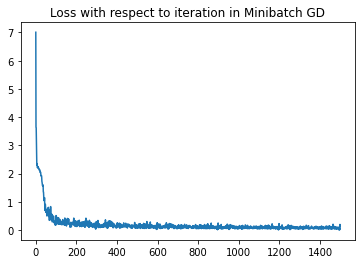

<Figure size 432x288 with 0 Axes>

In [122]:
with torch.no_grad():
  compressedTrainData = autoencoder(train_data.data.reshape(-1, 28*28).float())
  compressedTrainData = compressedTrainData.numpy()
  compressedTestData = autoencoder(test_data.data.reshape(-1, 28*28).float())
  compressedTestData = compressedTestData.numpy()

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, linear_cnn_95_acc = eval_CNN(train_loader, test_loader, epochs=5, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ",  linear_cnn_95_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## Comparison

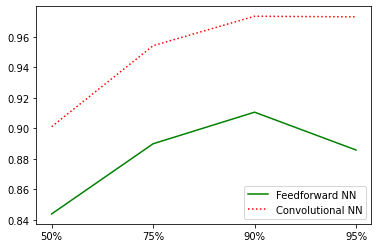

In [123]:
variance_levels = ['50%', '75%', '90%', '95%']
fnn_acc = [linear_ac_50_acc_fnn, linear_ac_75_acc_fnn, linear_ac_90_acc_fnn, linear_ac_95_acc_fnn]
cnn_acc = [linear_cnn_50_acc, linear_cnn_75_acc, linear_cnn_90_acc, linear_cnn_95_acc]
plt.plot(fnn_acc, linestyle='-', color='g', label='Feedforward NN')
plt.plot(cnn_acc, linestyle=':', color='r', label='Convolutional NN')
plt.xticks([0, 1, 2, 3], variance_levels)
plt.legend(loc='best')

**Inference**


*   For lower variance levels, the linear autoencoder performs way better than PCA. There was not any difference with CNN, but the performance of FNN was better with linear auto-encoders
*   Once, the variance level is around 75%, then the performance of them is similar.



# d) Non Linear Auto Encoder

In [0]:
# PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision for loading MNIST dataset
import torchvision
from torchvision import datasets, transforms

# For plotting
import matplotlib.pyplot as plt

from sklearn import decomposition
from tqdm.notebook import tqdm
from sklearn import datasets as skdatasets
import numpy as np

from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

In [0]:
mnist_transformer = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ])
# mnist_transformer = transforms.ToTensor()
# Download the training data
train_data = datasets.MNIST('./mnist_data', download=True, train=True,
                            transform=mnist_transformer)

compTrain_data = datasets.MNIST('./mnist_data', download=True, train=True,
                            transform=mnist_transformer)


# Download the test data
test_data = datasets.MNIST('./mnist_data', download=True, train=False,
                            transform=mnist_transformer)

In [0]:
class NonLinearAutoEncoderNet(nn.Module):

  def encode(self, x):
    x = self.fch1(x)
    x = F.relu(x)
    x = self.fch(x)
    x = F.relu(x)
    return x

  def decode(self, x):
    x = self.fco1(x)
    x = F.relu(x)
    x = self.fco(x)
    x = torch.sigmoid(x)
    return x

  def __init__(self, num_hidden_units=20):
    super(NonLinearAutoEncoderNet, self).__init__()
    self.fch1 = nn.Linear(784, 500)
    self.fch = nn.Linear(500, num_hidden_units)
    self.fco1 = nn.Linear(num_hidden_units, 500)
    self.fco = nn.Linear(500, 784)

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x

In [0]:
def train_non_linear_autoencoder(num_hidden_units, epochs=20, batch_size = 200):
  train_loader = DataLoader(train_data, batch_size=batch_size)
  test_loader = DataLoader(test_data,batch_size= batch_size)
  model = NonLinearAutoEncoderNet(num_hidden_units)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=(0.01/batch_size)) # lr = learning rate/step size
  # optimizer = optim.Adam(model.parameters(), lr=0.0001) # lr = learning rate/step size
  losses = []
  model = model.cuda()
  ##### Training the network ###################################################
  for e in tqdm(range(epochs)):  # loop over the dataset multiple times
    for data in train_loader:
      inputs, labels = data
      inputs = inputs.view(-1, 784)
      optimizer.zero_grad() # zero the parameter gradients
      inputs = inputs.cuda()
      outputs = model(inputs) # forward pass
      loss = criterion(outputs, inputs) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update
      losses.append(loss.item())
  plt.plot(losses)
  plt.figure()
  return model, losses

## 50% Variance

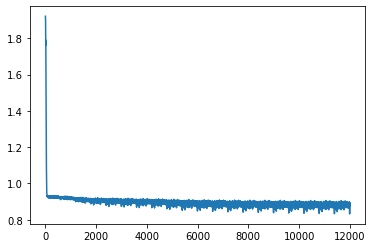

<Figure size 432x288 with 0 Axes>

In [81]:
Nonmodel, losses = train_non_linear_autoencoder(component_num_50, epochs=20, batch_size=100)

<class 'torch.Tensor'>
tensor(0)


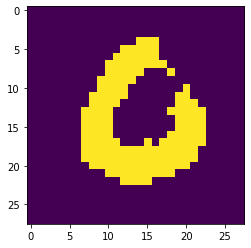

In [82]:
i = 3
with torch.no_grad():
    image = torch.Tensor(test_data.data[i,:].reshape(-1, 28*28).float())
    image = image.cuda()
    reconstructed_img = Nonmodel(image)
    reconstructed_img = reconstructed_img.cpu()
    print(type(reconstructed_img))
    plt.imshow(reconstructed_img.detach().numpy().reshape(28,28))    
    print(test_data.targets[i])

### FNN


Train Acc.. 0.86
Test Acc.. 0.8456


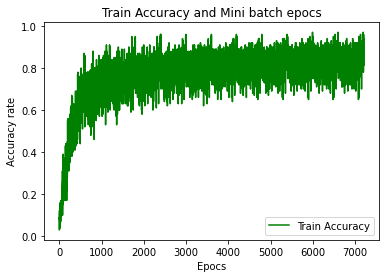

In [103]:
with torch.no_grad():
  compressedTrainData = Nonmodel.encode(torch.Tensor(mnist_train).cuda())
  compressedTestData = Nonmodel.encode(torch.Tensor(mnist_test).cuda())

model, train_acc = train_FNN(compressedTrainData.cpu().detach().numpy(), 50, epochs=12, batch=100)
non_linear_ac_50_acc_fnn = evaluate_NN(model, compressedTestData.cpu().detach().numpy(), test_data.targets)

print("Train Acc..", train_acc[-1])
print("Test Acc..", non_linear_ac_50_acc_fnn)


### CNN

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8181666666666667
Test accuracy:  0.8229


<Figure size 432x288 with 0 Axes>

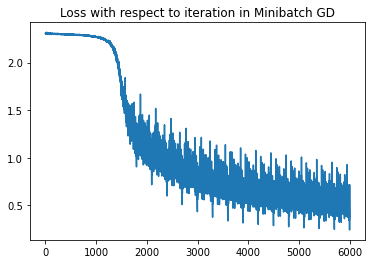

<Figure size 432x288 with 0 Axes>

In [101]:
with torch.no_grad():
  compressedTrainData = Nonmodel(train_data.data.reshape(-1, 28*28).float().cuda())
  compressedTrainData = compressedTrainData.cpu().detach().numpy()
  compressedTestData = Nonmodel(test_data.data.reshape(-1, 28*28).float().cuda())
  compressedTestData = compressedTestData.cpu().detach().numpy()

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, non_linear_cnn_50_acc = eval_CNN(train_loader, test_loader, epochs=20, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ",  non_linear_cnn_50_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## 75% Variance

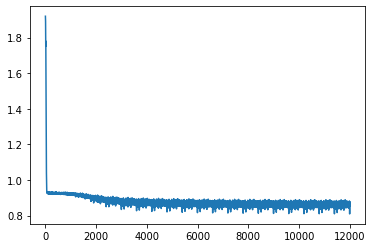

<Figure size 432x288 with 0 Axes>

In [85]:
Nonmodel, losses = train_non_linear_autoencoder(component_num_75, 20, batch_size=100)

### FNN


Train Acc.. 0.85
Test Acc.. 0.8308


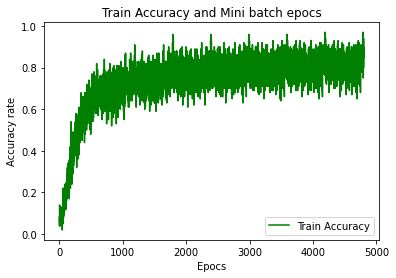

In [87]:
with torch.no_grad():
  compressedTrainData = Nonmodel.encode(torch.Tensor(mnist_train).cuda())
  compressedTestData = Nonmodel.encode(torch.Tensor(mnist_test).cuda())

model, train_acc = train_FNN(compressedTrainData.cpu().detach().numpy(), 50, epochs=8, batch=100)
non_linear_ac_75_acc_fnn = evaluate_NN(model, compressedTestData.cpu().detach().numpy(), test_data.targets)

print("Train Acc..", train_acc[-1])
print("Test Acc..", non_linear_ac_75_acc_fnn)

### CNN

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8081333333333334
Test accuracy:  0.8151


<Figure size 432x288 with 0 Axes>

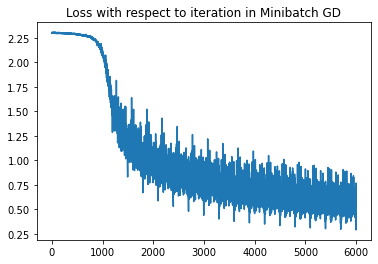

<Figure size 432x288 with 0 Axes>

In [88]:
with torch.no_grad():
  compressedTrainData = Nonmodel(train_data.data.reshape(-1, 28*28).float().cuda())
  compressedTrainData = compressedTrainData.cpu().detach().numpy()
  compressedTestData = Nonmodel(test_data.data.reshape(-1, 28*28).float().cuda())
  compressedTestData = compressedTestData.cpu().detach().numpy()

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, non_linear_cnn_75_acc = eval_CNN(train_loader, test_loader, epochs=20, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ",  non_linear_cnn_75_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## 90% Variance

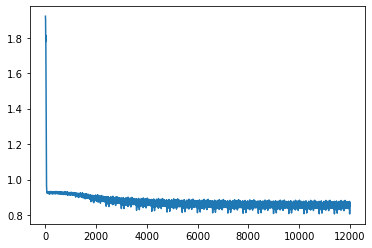

<Figure size 432x288 with 0 Axes>

In [89]:
model, losses = train_non_linear_autoencoder(component_num_90, 20, batch_size=100)

### FNN


Train Acc.. 0.85
Test Acc.. 0.8287


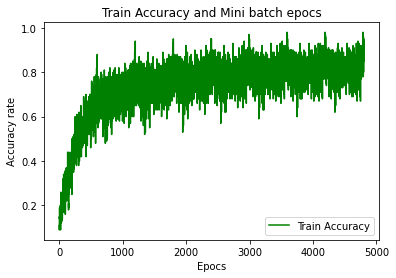

In [91]:
with torch.no_grad():
  compressedTrainData = Nonmodel.encode(torch.Tensor(mnist_train).cuda())
  compressedTestData = Nonmodel.encode(torch.Tensor(mnist_test).cuda())

model, train_acc = train_FNN(compressedTrainData.cpu().detach().numpy(), 50, epochs=8, batch=100)
non_linear_ac_90_acc_fnn = evaluate_NN(model, compressedTestData.cpu().detach().numpy(), test_data.targets)

print("Train Acc..", train_acc[-1])
print("Test Acc..", non_linear_ac_90_acc_fnn)

### CNN

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8025833333333333
Test accuracy:  0.8114


<Figure size 432x288 with 0 Axes>

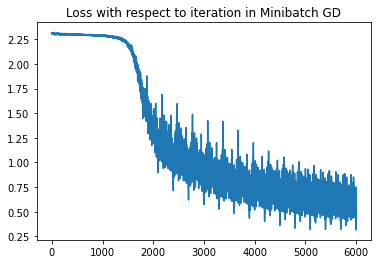

<Figure size 432x288 with 0 Axes>

In [92]:
with torch.no_grad():
  compressedTrainData = Nonmodel(train_data.data.reshape(-1, 28*28).float().cuda())
  compressedTrainData = compressedTrainData.cpu().detach().numpy()
  compressedTestData = Nonmodel(test_data.data.reshape(-1, 28*28).float().cuda())
  compressedTestData = compressedTestData.cpu().detach().numpy()

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, non_linear_cnn_90_acc = eval_CNN(train_loader, test_loader, epochs=20, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ",  non_linear_cnn_90_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## 95% Variance

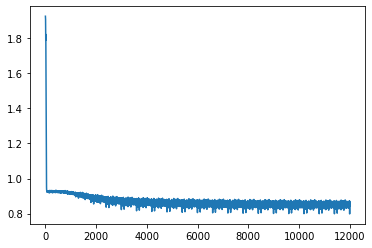

<Figure size 432x288 with 0 Axes>

In [93]:
model, losses = train_non_linear_autoencoder(component_num_95, 20, batch_size=100)

### FNN


Train Acc.. 0.84
Test Acc.. 0.8369


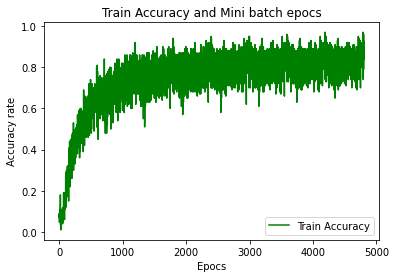

In [95]:
with torch.no_grad():
  compressedTrainData = Nonmodel.encode(torch.Tensor(mnist_train).cuda())
  compressedTestData = Nonmodel.encode(torch.Tensor(mnist_test).cuda())

model, train_acc = train_FNN(compressedTrainData.cpu().detach().numpy(), 50, epochs=8, batch=100)
non_linear_ac_95_acc_fnn = evaluate_NN(model, compressedTestData.cpu().detach().numpy(), test_data.targets)

print("Train Acc..", train_acc[-1])
print("Test Acc..", non_linear_ac_95_acc_fnn)

### CNN

Initializing the network ...
Training the network ...


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20

Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8109333333333333
Test accuracy:  0.8213


<Figure size 432x288 with 0 Axes>

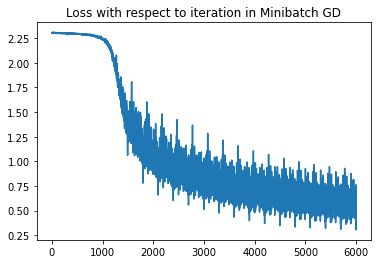

<Figure size 432x288 with 0 Axes>

In [96]:
with torch.no_grad():
  compressedTrainData = Nonmodel(train_data.data.reshape(-1, 28*28).float().cuda())
  compressedTrainData = compressedTrainData.cpu().detach().numpy()
  compressedTestData = Nonmodel(test_data.data.reshape(-1, 28*28).float().cuda())
  compressedTestData = compressedTestData.cpu().detach().numpy()

compressedTrainData = compressedTrainData.reshape(-1, 1, 28, 28)
compressedTestData = compressedTestData.reshape(-1, 1, 28, 28)

train_loader = create_dataloader(compressedTrainData, train_data.targets)
test_loader = create_dataloader(compressedTestData, test_data.targets)

losses, train_acc, non_linear_cnn_95_acc = eval_CNN(train_loader, test_loader, epochs=20, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ",  non_linear_cnn_95_acc)
plt.plot(losses)
plt.title("Loss with respect to iteration in Minibatch GD")
plt.figure()

## Comparison

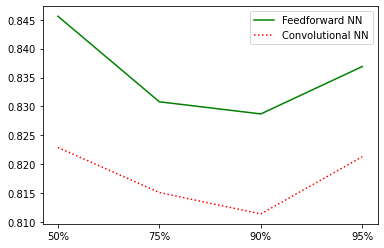

In [104]:
variance_levels = ['50%', '75%', '90%', '95%']
fnn_acc = [non_linear_ac_50_acc_fnn, non_linear_ac_75_acc_fnn, non_linear_ac_90_acc_fnn, non_linear_ac_95_acc_fnn]
cnn_acc = [non_linear_cnn_50_acc, non_linear_cnn_75_acc, non_linear_cnn_90_acc, non_linear_cnn_95_acc]
plt.plot(fnn_acc, linestyle='-', color='g', label='Feedforward NN')
plt.plot(cnn_acc, linestyle=':', color='r', label='Convolutional NN')
plt.xticks([0, 1, 2, 3], variance_levels)
plt.legend(loc='best')